<h1>
<center>Link Prediction Based Spatio-Temporal Graph Attention Networks
for PM2.5 pollutant Forecasting</center>
</h1>


In this notebook, we will dive into STGAT model where everything new meets  STGAT Attention + deep learning time series analysis on PM2.5 in Tehran air pollution dataset( spatio-temporal data) + link prediction, all in one notebook

In [292]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.sparse.linalg import eigs
from tensorboardX import SummaryWriter
import math
from typing import Optional, List, Union
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj
from torch_scatter import scatter_add
from geopy import distance
import pandas as pd
import numpy as np
import networkx as nx
from numpy.linalg import inv
import heapq
from geopy import distance
import pandas as pd
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import zipfile
import numpy as np
import torch
from torch_geometric.utils import dense_to_sparse
from six.moves import urllib
from torch_geometric_temporal.signal import temporal_signal_split

In [293]:
num = 100
torch.manual_seed(num)
random.seed(num)
np.random.seed(num)
# USE_CUDA = torch.is_available()
# DEVICE = torch.device('cpu')
# print("CUDA:", USE_CUDA, DEVICE)
sw = SummaryWriter(logdir='.', flush_secs=5)

## Loading the graph adjacency matrix (Spatial part)
to use other types of matrix generation uncomment below block

In [294]:
A = np.load('weather_adj_mat.npy')
G = nx.from_numpy_matrix(A)

In [295]:
stations = pd.read_excel('station_id.xlsx', sheet_name='Sheet1')
stations = stations.drop(labels=21, axis=0)
stations = stations.drop(labels=15, axis=0)
stations = stations.drop(labels=16, axis=0)
stations = stations.reset_index(drop=True)
station_ids = stations['id']
distance_matrix = np.zeros((19,19))
Latitude = stations['Latitude']
Longitude = stations['Longitude']
for i in range(19):
    for j in range(19):
        coords_1 = (Latitude[i], Longitude[i])
        coords_2 = (Latitude[j], Longitude[j])
        distance_matrix[i,j] = distance.geodesic(coords_1, coords_2).km 

# add edge

In [296]:
def centrality_based(centrality_metric, graph, num_top, num_selected):

    # these ones return a Dictionary of nodes with centrality as the value.
    if centrality_metric == 'closeness':
        centrality = nx.closeness_centrality(graph)
    elif centrality_metric == 'degree':
        centrality = nx.degree_centrality(graph)
    elif centrality_metric == 'eigenvector':
        graph = nx.DiGraph(graph)
        centrality = nx.eigenvector_centrality(graph)
    elif centrality_metric == 'betweenness':
        graph = nx.DiGraph(graph)
        centrality = nx.betweenness_centrality(graph)
    elif centrality_metric == 'load':
        centrality = nx.load_centrality(graph)
    elif centrality_metric == 'subgraph':
        graph = nx.Graph(graph)
        centrality = nx.subgraph_centrality(graph)
    elif centrality_metric == 'harmonic':
        centrality = nx.harmonic_centrality(graph)
    important_nodes = heapq.nlargest(num_top, centrality, key=centrality.get)
    for item in important_nodes:
        selected_nodes = np.random.choice(graph.nodes(), num_selected)
        important_node = np.ones(len(selected_nodes))*item
        for i in range(len(selected_nodes)):
            for j in range(len(important_node)):
                if distance_matrix[i,j]!=0:
                    A[i,j] = 1/distance_matrix[i,j]
    return A


def link_prediction_based(pred_metric, graph, num_top):

    graph = nx.Graph(graph)
    if pred_metric == 'jaccard':
        centrality = nx.jaccard_coefficient(graph)
    elif pred_metric == 'common_neighbor':
        centrality = nx.common_neighbor_centrality(graph)
    elif pred_metric == 'preferential_attachment':
        centrality = nx.preferential_attachment(graph)
    elif pred_metric == 'resource_allocation':
        centrality = nx.resource_allocation_index(graph)
    elif pred_metric == 'adamic_adar':
        centrality = nx.adamic_adar_index(graph)        
    centrality = {item[:2]: item[2]  for item in centrality}
    new_edges = heapq.nlargest(num_top, centrality, key=centrality.get)
    new_edges = np.array(new_edges)
    for i in range(len(new_edges)):
        x,y = new_edges[i,0],new_edges[i,1]
        A[x,y] = 1/distance_matrix[x,y]
    return A

A = np.load('weather_adj_mat.npy')
G = nx.from_numpy_matrix(A)
A = centrality_based('closeness', G, 5, 1)
np.save('weather_adj_mat_new.npy', A)
rows, cols = np.where(A != 1)
edge_index_data = torch.LongTensor(np.array([rows, cols]))

# Loading the data (Temporal part)


In [297]:
with open('weather_node_values_new.npy', 'rb') as f:
    tweets_data_previous_hours_train = np.load(f)


# Creating the DataLoaders

In [318]:
class AirPollutionDatasetLoader(object):

    def __init__(self,):
        super(AirPollutionDatasetLoader, self).__init__()
        # self.raw_data_dir = raw_data_dir
        self._read_web_data()

    def _download_url(self, url, save_path):  # pragma: no cover
        with urllib.request.urlopen(url) as dl_file:
            with open(save_path, "wb") as out_file:
                out_file.write(dl_file.read())

    def _read_web_data(self):


        A = np.load("./weather_adj_mat_new.npy")
        self.A = torch.from_numpy(A)
        X = np.load("./weather_node_values_new.npy")
        X = X.astype(np.float32)
        temp = X
        for i in range(8) :
            X = temp[:,:,i]
        # Normalise via Z-Score Method
            means = np.mean(X)
            print(means)
            X = X - means
            stds = np.std(X)
            X = X / stds
            temp[:,:,i] = X
        self.X = torch.from_numpy(temp)
        print(self.X.shape)

    def _get_edges_and_weights(self):
        edge_indices, values = dense_to_sparse(self.A)
        edge_indices = edge_indices.numpy()
        values = values.numpy()
        self.edges = edge_indices
        self.edge_weights = values

    def _generate_task(self, num_timesteps_in: int = 12, num_timesteps_out: int = 1):
       
        indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(self.X.shape[0] - (num_timesteps_in + num_timesteps_out) + 1)
        ]
        features, target = [], []
        for i, j in indices:
            features.append((self.X[ i : i + num_timesteps_in,:,:]).numpy())
            target.append((self.X[ i + num_timesteps_in : j,:,0]).numpy())
        self.features = features
        self.targets = target

    def get_dataset(
        self, num_timesteps_in: int = 12, num_timesteps_out: int = 1
    ) -> StaticGraphTemporalSignal:
        self._get_edges_and_weights()
        self._generate_task(num_timesteps_in, num_timesteps_out)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )
        return dataset

In [319]:
loader = AirPollutionDatasetLoader()
dataset = loader.get_dataset(num_timesteps_in = 12, num_timesteps_out= 1)
dataset_ = np.array(list(dataset.features))
a, b, c , d = np.array(list(dataset.features)).shape
dataset_ = dataset_.reshape(a,c, d, b)
dataset_.shape
dataset.features = dataset_
dataset_ = np.array(list(dataset.targets))
a, b, c = np.array(list(dataset.targets)).shape
dataset_ = dataset_.reshape(a,c,b)
dataset_.shape
dataset.targets = dataset_

85.0058
9.153586
1016.07367
0.27147993
37.53304
18.185081
202.95992
0.0
torch.Size([2543, 19, 8])


/tmp/ipykernel_10697/2539838172.py:28: RuntimeWarning: invalid value encountered in true_divide
  X = X / stds


In [300]:
shuffle=True
batch_size = 16
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

train_x_tensor = torch.from_numpy(np.array(train_dataset.features)).type(torch.FloatTensor)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(np.array(train_dataset.targets)).type(torch.FloatTensor)  # (B, N, T)
train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

test_x_tensor = torch.from_numpy(np.array(test_dataset.features)).type(torch.FloatTensor)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(np.array(test_dataset.targets)).type(torch.FloatTensor)  # (B, N, T)
test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

print('train:', train_x_tensor.size(), train_target_tensor.size())
print('test:', test_x_tensor.size(), test_target_tensor.size())

train: torch.Size([506, 19, 8, 12]) torch.Size([506, 19, 1])
test: torch.Size([2025, 19, 8, 12]) torch.Size([2025, 19, 1])


# Defining Layers

## Temporal attention layer


In [301]:
class TemporalAttention(nn.Module):
    
    def __init__(self, in_channels: int, num_of_vertices: int, num_of_timesteps: int, DEVICE = torch.device('cpu')):
        super(TemporalAttention, self).__init__()

        self._U1 = nn.Parameter(torch.FloatTensor(num_of_vertices))  # N
        self._U2 = nn.Parameter(torch.FloatTensor(in_channels)) # F
        self._U3 = nn.Parameter(torch.FloatTensor(num_of_timesteps)) # T
        self._U4 = nn.Parameter(torch.FloatTensor(num_of_timesteps)) # T
        self._reset_parameters()
        self._LHS = torch.FloatTensor(num_of_timesteps) # T
        self._RHS = torch.FloatTensor(num_of_timesteps) # T
        
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)
                
    def _generate_LHS_RHS(self,X):
        self._LHS = torch.mul(X,self._U3)
        self._RHS = torch.mul(X,self._U4)  
        
    def _aggregate(self,type_ensemble = 'sum') :
        size=np.array(self._LHS.size()).tolist()
        size.append(size[1])
        e = torch.FloatTensor(size[0],size[1],size[2])
        if type_ensemble == 'sum' :
            for b in range(size[0]): # b
                for i in range(size[1]): #N
                    for j in range (size[2]) : #N
                        e[b,i,j] = self._LHS[b,i] + self._RHS[b,j]
        return e

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        x = torch.permute(X,(0,3,2,1)) # (b,N,F,T) -> (b,T,F,N)
        x = torch.matmul(torch.matmul(x, self._U1),self._U2) # (b,T,F,N)(N)->(b,T,F)-> (b,T)
        self._generate_LHS_RHS(x) #(b,T) , (b,T)
        type_ensemble = 'sum'
        e = self._aggregate(type_ensemble) #(b,T,T)
        e = F.softmax(torch.sigmoid(e),dim = 1) #(b,T,T)
        return e
        

## Spatial attention layer


In [302]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels: int, num_of_vertices: int, num_of_timesteps: int, DEVICE = torch.device('cpu')):
        super(SpatialAttention, self).__init__()
        self._W1 = nn.Parameter(torch.FloatTensor(num_of_timesteps))  # T
        self._W2 = nn.Parameter(torch.FloatTensor(in_channels))  # F
        self._W3 = nn.Parameter(torch.FloatTensor(num_of_vertices))   # N
        self._W4 = nn.Parameter(torch.FloatTensor(num_of_vertices))   # N
        self._reset_parameters()
        self._LHS = torch.FloatTensor( num_of_vertices) #N
        self._RHS = torch.FloatTensor( num_of_vertices) #N

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)
    
    def _generate_LHS_RHS(self,X):
        self._LHS = torch.mul(X,self._W3)
        self._RHS = torch.mul(X,self._W4)  
        
    def _aggregate(self,type_ensemble = 'sum') :
        size=np.array(self._LHS.size()).tolist()
        size.append(size[1])
        s = torch.FloatTensor(size[0],size[1],size[2])
        if type_ensemble == 'sum' :
            for b in range(size[0]): # b
                for i in range(size[1]): #N
                    for j in range (size[2]) : #N
                        s[b,i,j] = self._LHS[b,i] + self._RHS[b,j]
        return s

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        X = torch.matmul(torch.matmul(x, self._W1),self._W2) # (b,N,F,T)(T)->(b,N,F)-> (b,N)
        self._generate_LHS_RHS(X) #(b,N) , (b,N)
        type_ensemble = 'sum'
        s = self._aggregate(type_ensemble) #(b,N,N)
        s = F.softmax(torch.sigmoid(s),dim = 1) #(b,N,N)
        return s

## GCN

### Compute graph Laplacian


In [303]:
class ChebConvAttention(MessagePassing):
    
    def __init__(self, in_channels: int,out_channels: int,K: int, normalization: Optional[str] = None, bias: bool = True,**kwargs):
        kwargs.setdefault("aggr", "add")
        super(ChebConvAttention, self).__init__(**kwargs)
        assert K > 0
        assert normalization in [None, "sym", "rw"], "Invalid normalization"

        self._in_channels = in_channels
        self._out_channels = out_channels
        self._normalization = normalization
        self._weight = Parameter(torch.Tensor(K, in_channels, out_channels))  #    self.Theta  [3, 1, 64]
        if bias:
            self._bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter("_bias", None)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self._weight)
        if self._bias is not None:
            nn.init.uniform_(self._bias)
            
    def __norm__( self, edge_index, num_nodes: Optional[int], edge_weight: OptTensor,normalization: Optional[str],  lambda_max, 
                 dtype: Optional[int] = None, batch: OptTensor = None ):
        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        edge_index, edge_weight = get_laplacian(edge_index, edge_weight, normalization, dtype, num_nodes)
        if batch is not None and lambda_max.numel() > 1:
            lambda_max = lambda_max[batch[edge_index[0]]]
        edge_weight = (2.0 * edge_weight) / lambda_max
        edge_weight.masked_fill_(edge_weight == float("inf"), 0)
        assert edge_weight is not None
        return edge_index, edge_weight # 307 nodes as deg, 340 edges , 307 nodes as self connections

    
    def forward(self, x: torch.FloatTensor, edge_index: torch.LongTensor, spatial_attention: torch.FloatTensor, 
                edge_weight: OptTensor = None, batch: OptTensor = None, lambda_max: OptTensor = None,) -> torch.FloatTensor:
        if self._normalization != "sym" and lambda_max is None:
            raise ValueError( "You need to pass `lambda_max` to `forward() in case the normalization is non-symmetric.")
        if lambda_max is None:
            lambda_max = torch.tensor(2.0, dtype=x.dtype, device=x.device)
        if not isinstance(lambda_max, torch.Tensor):
            lambda_max = torch.tensor(lambda_max, dtype=x.dtype, device=x.device)
        assert lambda_max is not None
        edge_index, norm = self.__norm__(edge_index, x.size(self.node_dim), edge_weight, self._normalization, lambda_max, 
                                         dtype=x.dtype, batch=batch)
        row, col = edge_index # refer to the index of each note each is a list of nodes not a number # (954, 954)   
        Att_norm = norm * spatial_attention[:, row, col] # spatial_attention (32, 307, 307), -> (954) * (32, 954) -> (32, 954)
        num_nodes = x.size(self.node_dim) # 307
        # (307, 307) * (32, 307, 307) -> (32, 307, 307) -permute-> (32, 307,307) * (32, 307, 1) -> (32, 307, 1)
        TAx_0 = torch.matmul((torch.eye(num_nodes).to(edge_index.device) * spatial_attention).permute( 0, 2, 1), x) # (32, 307, 1)
        out = torch.matmul(TAx_0, self._weight[0]) # (32, 307, 1) * [1, 64] -> (32, 307, 64)
        edge_index_transpose = edge_index[[1, 0]]
        if self._weight.size(0) > 1: # Do once
            TAx_1 = self.propagate( edge_index_transpose, x=TAx_0, norm=Att_norm, size=None)
            out = out + torch.matmul(TAx_1, self._weight[1])
        for k in range(2, self._weight.size(0)): # Do once
            TAx_2 = self.propagate(edge_index_transpose, x=TAx_1, norm=norm, size=None)
            TAx_2 = 2.0 * TAx_2 - TAx_0
            out = out + torch.matmul(TAx_2, self._weight[k])
            TAx_0, TAx_1 = TAx_1, TAx_2
        if self._bias is not None:
            out += self._bias
        return out #? (b, N, F_out) (32, 307, 64)

    def message(self, x_j, norm):
        if norm.dim() == 1: # do this
            return norm.view(-1, 1) * x_j  # (954, 1) * (32, 954, 1) -> (32, 954, 1)
        else:
            d1, d2 = norm.shape
            return norm.view(d1, d2, 1) * x_j

    def __repr__(self):
        return "{}({}, {}, K={}, normalization={})".format(self.__class__.__name__,self._in_channels,self._out_channels,self._weight.size(0),self._normalization,)

# The ASTGCN block

In [304]:
class ASTGCNBlock(nn.Module):
    
    def __init__(self, in_channels: int,K: int,nb_chev_filter: int,nb_time_filter: int,time_strides: int,num_of_vertices: int,
        num_of_timesteps: int,normalization: Optional[str] = None,bias: bool = True, DEVICE = torch.device('cpu')):
        super(ASTGCNBlock, self).__init__()
        self._temporal_attention = TemporalAttention(in_channels, num_of_vertices, num_of_timesteps, DEVICE)
        self._spatial_attention = SpatialAttention(in_channels, num_of_vertices, num_of_timesteps, DEVICE)
        self._chebconv_attention = ChebConvAttention(in_channels, nb_chev_filter, K, normalization, bias)
        self._time_convolution = nn.Conv2d( nb_chev_filter,nb_time_filter,kernel_size=(1, 3), stride=(1, time_strides),padding=(0, 1))
        self._residual_convolution = nn.Conv2d(in_channels, nb_time_filter, kernel_size=(1, 1), stride=(1, time_strides))
        self._layer_norm = nn.LayerNorm(nb_time_filter) #channel
        self._normalization = normalization
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)

    def forward(self, X: torch.FloatTensor, edge_index: Union[torch.LongTensor, List[torch.LongTensor]]) -> torch.FloatTensor:
        batch_size, num_of_vertices, num_of_features, num_of_timesteps = X.shape  # (32, 307, 1, 12)
        X_tilde = self._temporal_attention(X) # (b, T, T)  (32, 12, 12) * reshaped x(32, 307, 12)  -reshape> (32, 307, 1, 12)
        X_tilde = torch.matmul(X.reshape(batch_size, -1, num_of_timesteps), X_tilde)
        X_tilde = X_tilde.reshape(batch_size, num_of_vertices, num_of_features, num_of_timesteps)
        X_tilde = self._spatial_attention(X_tilde) # (32, 307, 307)
        if not isinstance(edge_index, list):
            data = Data(edge_index=edge_index, edge_attr=None, num_nodes=num_of_vertices)
            if self._normalization != "sym":
                lambda_max = LaplacianLambdaMax()(data).lambda_max
            else:
                lambda_max = None
            X_hat = []
            for t in range(num_of_timesteps):
                X_hat.append(torch.unsqueeze( self._chebconv_attention(X[:, :, :, t], edge_index, X_tilde, lambda_max=lambda_max), -1))
            X_hat = F.relu(torch.cat(X_hat, dim=-1))
        else:
            X_hat = []
            for t in range(num_of_timesteps):
                data = Data(edge_index=edge_index[t], edge_attr=None, num_nodes=num_of_vertices)
                if self._normalization != "sym":
                    lambda_max = LaplacianLambdaMax()(data).lambda_max
                else:
                    lambda_max = None
                X_hat.append(torch.unsqueeze(self._chebconv_attention(X[:, :, :, t], edge_index[t], X_tilde, lambda_max=lambda_max),-1,))
            X_hat = F.relu(torch.cat(X_hat, dim=-1))

        X_hat = self._time_convolution(X_hat.permute(0, 2, 1, 3))   # (b,N,F,T)->(b,F,N,T) (1,3)->(b,F,N,T) (32, 64, 307, 12)
        X = self._residual_convolution(X.permute(0, 2, 1, 3)) # (b,N,F,T)->(b,F,N,T) (1,1)->(b,F,N,T)  (32, 64, 307, 12)
        X = self._layer_norm(F.relu(X + X_hat).permute(0, 3, 2, 1))
        X = X.permute(0, 2, 3, 1)
        return X

# model structure


In [305]:
class ASTGCN(nn.Module):
    
    def __init__( self,  nb_block: int, in_channels: int,  K: int, nb_chev_filter: int,  nb_time_filter: int,  time_strides: int,
        num_for_predict: int,len_input: int, num_of_vertices: int, normalization: Optional[str] = None,bias: bool = True, DEVICE = torch.device('cpu')):
        super(ASTGCN, self).__init__()
        self._blocklist = nn.ModuleList([ASTGCNBlock( in_channels, K, nb_chev_filter, nb_time_filter,time_strides, num_of_vertices, 
                                                     len_input, normalization,bias, DEVICE)])
        self._blocklist.extend( [ASTGCNBlock( nb_time_filter,  K, nb_chev_filter, nb_time_filter, 1, num_of_vertices, 
                                             len_input // time_strides, normalization,  bias, DEVICE)  for _ in range(nb_block - 1) ]) # nb_block= 2
        self._final_conv = nn.Conv2d( int(len_input / time_strides),   num_for_predict,  kernel_size=(1, nb_time_filter))
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)
                
    def forward(  self, X: torch.FloatTensor, edge_index: torch.LongTensor ) -> torch.FloatTensor:
        for block in self._blocklist:
            X = block(X, edge_index) 
        X = self._final_conv(X.permute(0, 3, 1, 2))
        X = X[:, :, :, -1]
        X = X.permute(0, 2, 1) 
        return X 

# Run Model


In [306]:
nb_block = 2
in_channels = 8
K = 3
nb_chev_filter = 64
nb_time_filter = 64
time_strides = 1 #num_of_hours
num_for_predict = 1
len_input = 12
num_of_vertices = 19
learning_rate = 0.0001

def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
masked_flag=0
criterion = nn.L1Loss()
criterion_masked = masked_mae
loss_function = 'mse'
metric_method = 'unmask'
missing_value=0.0
loss_function = 'rmse'
if loss_function=='masked_mse':
    criterion_masked = masked_mse         #nn.MSELoss().to(DEVICE)
    masked_flag=1
elif loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss()
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss()
    masked_flag= 0


In [307]:
def compute_val_loss_mstgcn(net, val_loader, criterion,  masked_flag,missing_value,sw, epoch, edge_index_data, limit=None):
    net.train(False)  # ensure dropout layers are in evaluation mode
    with torch.no_grad():
        val_loader_length = len(val_loader)  # nb of batch
        tmp = []  # batch loss
        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs, edge_index_data)
            if masked_flag:
                loss = criterion(outputs, labels, missing_value)
            else:
                loss = criterion(outputs, labels)
            tmp.append(loss.item())
            if batch_index % 100 == 0:
                print('validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
        sw.add_scalar('validation_loss', validation_loss, epoch)
    return validation_loss

In [308]:
global_step = 0
best_epoch = 0
best_val_loss = np.inf
start_time= time()

In [309]:
masked_flag

0

In [310]:
# train model
for epoch in range(10):
    params_filename = os.path.join('./', 'epoch_%s.params' % epoch)
    masked_flag = 1
    if masked_flag:
        val_loss = compute_val_loss_mstgcn(net, train_loader, criterion_masked, masked_flag,missing_value,sw, epoch,edge_index_data)
    else:
        val_loss = compute_val_loss_mstgcn(net, train_loader, criterion, masked_flag, missing_value, sw, epoch,edge_index_data)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
#         torch.save(net.state_dict(), params_filename)
#         print('save parameters to file: %s' % params_filename)

    net.train()  
    for _ in range(10):
        for batch_index, batch_data in enumerate(train_loader):
            encoder_inputs, labels = batch_data   # encoder_inputs torch.Size([32, 307, 1, 12])  label torch.Size([32, 307, 12])
            optimizer.zero_grad()
            outputs = net(encoder_inputs, edge_index_data) # torch.Size([32, 307, 12])

            if masked_flag:
                loss = criterion_masked(outputs, labels,missing_value)
            else :
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss = loss.item()
            global_step += 1
            sw.add_scalar('training_loss', training_loss, global_step)

            if global_step % 100 == 0:
                print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))
#             if global_step % 200 == 0:
#                 #plt.plot(np.concatenate([encoder_inputs[0][0][0].cpu().numpy(), labels[0][0].cpu().numpy()]))
#                 plt.plot(range(12),encoder_inputs[0][0][0].cpu().numpy(), color = 'red')
#                 plt.plot(range(12,96), labels[0][0].cpu().numpy(), color='blue')
#                 plt.show()
#                 plt.plot(range(12),encoder_inputs[0][0][0].cpu().numpy(), color = 'red')
#                 plt.plot(range(12,96), outputs[0][0].detach().cpu().numpy(), color='blue')
#                 plt.show()


validation batch 1 / 32, loss: 0.69
global step: 100, training loss: 0.09, time: 105.54s
global step: 200, training loss: 0.09, time: 204.48s
global step: 300, training loss: 0.08, time: 302.97s
validation batch 1 / 32, loss: 0.09
global step: 400, training loss: 0.08, time: 407.69s
global step: 500, training loss: 0.08, time: 506.46s
global step: 600, training loss: 0.08, time: 605.17s
validation batch 1 / 32, loss: 0.08
global step: 700, training loss: 0.08, time: 710.24s
global step: 800, training loss: 0.08, time: 808.74s
global step: 900, training loss: 0.08, time: 907.59s
validation batch 1 / 32, loss: 0.08
global step: 1000, training loss: 0.09, time: 1012.73s
global step: 1100, training loss: 0.09, time: 1111.61s
global step: 1200, training loss: 0.09, time: 1211.46s
validation batch 1 / 32, loss: 0.07
global step: 1300, training loss: 0.08, time: 1316.41s
global step: 1400, training loss: 0.07, time: 1415.44s
global step: 1500, training loss: 0.08, time: 1514.42s
global step: 

In [311]:
#  s = torch.Tensor.new_zeros(size = (16,19,19),dtype=torch.float64)
tensor = torch.zeros((16,19,19))

# Testing the model

In [312]:
net.train(False) 
output = []
label = []
with torch.no_grad():
    test_loader_length = len(test_loader)  # nb of batch
    tmp = []  # batch loss
    for batch_index, batch_data in enumerate(test_loader):
        encoder_inputs, labels = batch_data
        outputs = net(encoder_inputs, edge_index_data)
        for i in range(len(outputs)):
            output.append(outputs[i])
            label.append(labels[i])
        loss = criterion(outputs, labels)
        tmp.append(loss.item())
        if batch_index % 100 == 0:
            print('test_loss batch %s / %s, loss: %.2f' % (batch_index + 1, test_loader_length, loss.item()))

    test_loss = sum(tmp) / len(tmp)
    sw.add_scalar('test_loss', test_loss, epoch)
print(test_loss)
print(len(label))

test_loss batch 1 / 127, loss: 0.01
test_loss batch 101 / 127, loss: 0.01
0.009409702133651323
2025


[-0.26326558 -0.30602822 -0.3156931  ... -0.269601   -0.2400112
 -0.32912228]
Data points:, (2025,)


<AxesSubplot:>

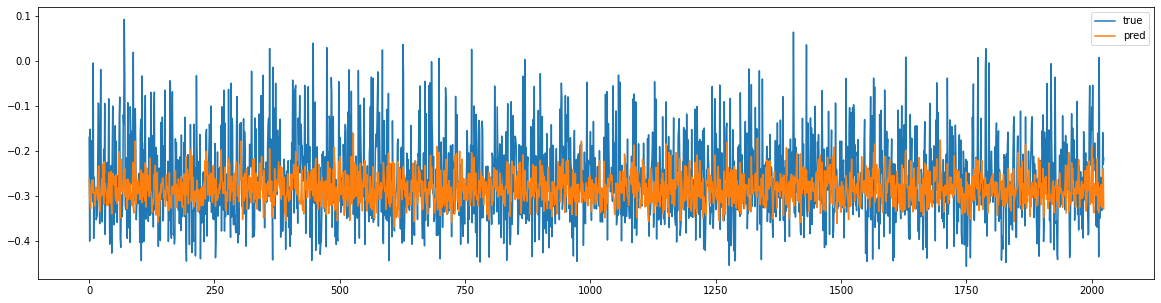

In [313]:
import seaborn as sns
sensor = 1
timestep = 0
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in output])
print(preds)
labs  = np.asarray([l[sensor][timestep].cpu().numpy() for l in label])
print("Data points:,", preds.shape)
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=labs, label="true")
sns.lineplot(data=preds, label="pred")